{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/storage/DATA/pak'}

/storage/DATA/pak/cuhk03_release found :)
/storage/DATA/pak/Market-1501-v15.09.15 found :)
/storage/DATA/pak/DukeMTMC-reID found :)
found memmaped /storage/DATA/pak/cuhk03_release/labeled64x128.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_test128x64.npy
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_train128x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
is same: [0 1]


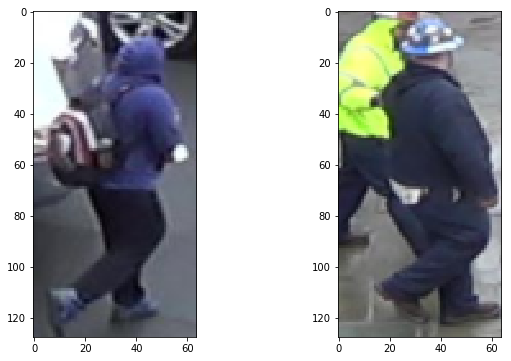

In [13]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

sampler = DataSampler(root, 64, 128)

x, y = sampler.get_test_batch(5, 5)

pid = 0
print('is same:', y[pid])
im = x[pid]
fig = plt.figure(figsize=(10, 6))
fig.add_subplot(121).imshow(im[:,:,0:3])
fig.add_subplot(122).imshow(im[:,:,3:6])
plt.show()

In [61]:
from time import time
from pak.datasets.UMPM import UMPM

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

mpm = UMPM(root, user, pwd)

_start = time()
X, Y, Calib = mpm.get_data('p2_chair_2')
_end = time()
print('elapsed', _end - _start)

print(Calib.keys())

/storage/DATA/pak
UMPM
elapsed 1.5874900817871094
dict_keys(['l', 'r', 's', 'f'])


(486, 644, 3)
UMPM
same [1 0]


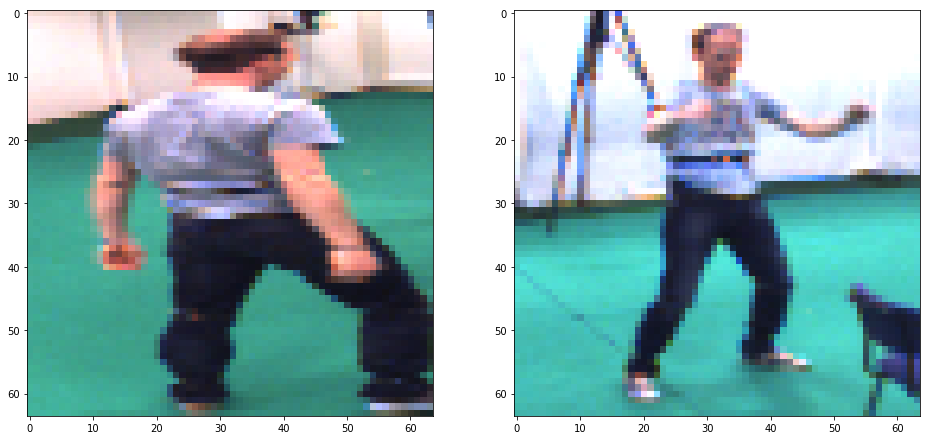

In [131]:
import numpy as np
import numpy.linalg as la
import cv2
from numpy.random import randint
from random import random


def get_bb(cam, pts3d):
    """ return (x, y, w, h)
    """
    assert len(pts3d) == 15
    rvec = np.array(cam['rvec']).astype('float32')
    tvec = np.array(cam['tvec']).astype('float32')
    K = cam['K'].astype('float32')
    distCoef = np.array(cam['distCoeff']).astype('float32')
    pts2d = np.squeeze(cv2.projectPoints(pts3d.astype('float32'), 
                                         rvec, 
                                         tvec, K, distCoef)[0])
    
    x_max = np.max(pts2d[:,0])
    x_min = np.min(pts2d[:,0])
    y_max = np.max(pts2d[:,1])
    y_min = np.min(pts2d[:,1])
    
    n1, n2, n3, n4 = randint(0, 50, 4)
    y = max(y_min - n1, 0)
    x = max(x_min - n2, 0)
    w = min(x_max - x + n3, 644)
    h = min(y_max - y + n4, 486)
    return int(x), int(y), int(w), int(h)

class UMPMSampler:
    
    def __init__(self, root, 
                 umpm_datasets, umpm_user, umpm_password, w, h):
        """
        :param root: root folder for data
        :param umpm_datasets [{string}, ... ] defines which datasets are
            being used for
        :param umpm_user: must be set if len(umpm_datasets) > 0
        :param umpm_password: must be set if len(umpm_datasets) > 0
        """
        self.n = len(umpm_datasets)
        assert self.n > 0
        umpm = UMPM(root, umpm_user, umpm_password)
        self.cameras = ['l', 'r', 's', 'f']
        self.Xs = []
        self.Ys = []
        self.Calibs = []
        for ds in umpm_datasets:
            X, Y, Calib = umpm.get_data(ds)
            self.Xs.append(X)
            self.Ys.append(Y)
            self.Calibs.append(Calib)
        self.w = w
        self.h = h
    
    def get_random_sample(self, start, end, same_person):
        """ 
        :param start: {int} start frame
        :param end: {int} end frame
        :param same_person: {boolean}
        """
        person1 = randint(0, 2)
        if same_person:
            person2 = person1
        else:
            person2 = 0 if person1 == 1 else 1
            
        dataset = randint(0, self.n)  # choose dataset
        frame1, frame2 = randint(start, end, 2)  # frames
        cid1, cid2 = randint(0, 4, 2)  # camera
        cid1 = self.cameras[cid1]
        cid2 = self.cameras[cid2]
        cam1 = self.Calibs[dataset][cid1]
        cam2 = self.Calibs[dataset][cid2]
        
        X1 = self.Xs[dataset][cid1][frame1]
        X2 = self.Xs[dataset][cid2][frame2]
        
        start1 = person1 * 15
        pts3d_1 = self.Ys[dataset][frame1][start1:start1+15,0:3]
        x1, y1, w1, h1 = get_bb(cam1, pts3d_1)

        start2 = person2 * 15
        pts3d_2 = self.Ys[dataset][frame2][start2:start2+15,0:3]
        x2, y2, w2, h2 = get_bb(cam2, pts3d_2)
        
        im1 = X1[y1:y1+h1, x1:x1+w1]
        im2 = X2[y2:y2+h2, x2:x2+w2]
        return cv2.resize(im1, (self.w, self.h)), cv2.resize(im2, (self.w, self.h))
        
        
    def get_test(self, batch_size=16):
        """ take the first 100 frames as test set
        """
        start = 0
        end = 100
        X = []
        Y = []
        for i in range(32):
            same_person = random() > 0.5
            im1, im2 = self.get_random_sample(start, end, same_person)
            X.append((im1, im2))
            Y.append([1, 0] if same_person else [0, 1])
        
        return np.array(X), np.array(Y)
        

f = 100
cid = 'l'
im = X[cid][f]
y = Y[f]
cam = Calib[cid]
H, W, _ = im.shape
print(im.shape)

rvec = np.array(cam['rvec']).astype('float32')
tvec = np.array(cam['tvec']).astype('float32')
K = cam['K'].astype('float32')
distCoef = np.array(cam['distCoeff']).astype('float32')



umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, 64, 64)


x, y = umpm_sampler.get_test()

print('same', y[0])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0][0])
ax = fig.add_subplot(122)
ax.imshow(x[0][1])
plt.show()

In [2]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

filepath = join('data_storage', 'model.h5')

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

if isfile(filepath):
    model = load_model(filepath)
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        3520      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [3]:
# def generate_training_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_train_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# def generate_validation_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_test_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# history = model.fit_generator(generate_training_data(),
#                     validation_data=generate_validation_data(),
#                     validation_steps=5,
#                     steps_per_epoch=100,
#                     epochs=1000,
#                     callbacks=callbacks_list)